# Regressi K-NN dan Decision Tree untuk Prediksi `aveOralM`

Notebook ini membangun dua model regresi: **K-Nearest Neighbors (K-NN)** dan **Decision Tree** untuk memprediksi nilai rata-rata suhu mulut (`aveOralM`) menggunakan dataset suhu inframerah manusia.

Evaluasi dilakukan menggunakan:
- **Mean Squared Error (MSE)**: $$MSE = \frac{1}{n} \sum_{i=1}^{n}(y_i - \hat{y}_i)^2 $$
- **Root Mean Squared Error (RMSE)**: $$RMSE = \sqrt{MSE} $$
- **R-squared (R²)**: $$ R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2} $$


In [66]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, roc_curve, confusion_matrix)
import matplotlib.pyplot as plt

### Import Data

In [76]:
df = pd.read_csv("income.csv")
df.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Membersihkan Data

In [77]:
# Mengecek nilai kosong dan menghapusnya jika ada
print("Jumlah nilai kosong per kolom:\n", df.isnull().sum())
df = df.dropna()

data = df

Jumlah nilai kosong per kolom:
 age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64


### Encode dan Memisah Fitur Data
tahap ini bertujuan untuk memisahkan kolom fitur yang akan dijadikan parameter dengan kolom yang akan menjadi label untuk diprediksi `"aveOralM"`.
- **Encode:** Untuk kolom yang tipe datanya bukan numerik:
```
"workclass", "education", "marital-status", "occupation",
"relationship", "race", "sex", "native-country"
```
  - Mengubah kolom kategorikal menjadi numerikal
  - Untuk kolom "income", terdapat data yang memiliki duplikat namun memiliki makna yang sama, yaitu "<=50K" dengan "<=50K." dan ">50K" dengan ">50K."
- **Memisahkan data:** Data dipisah 70% untuk training model dan 30% untuk testing model. Dengan begini kita bisa mendapat model yang dapat diuji akurasinya.

In [78]:
# Encode categorical variables
categorical_cols = ["workclass", "education", "marital-status", "occupation",
                   "relationship", "race", "sex", "native-country"]

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

df['income'] = df['income'].map({'<=50K': 0, '>50K': 1, '<=50K.': 0, '>50K.': 1})

# Split features and target
X = data.drop('income', axis=1)
y = data['income']

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### K-Nearest Neighbors (K-NN) Regressor

In [79]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Find optimal k
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': range(1, 20)}
knn_grid = GridSearchCV(knn, param_grid, cv=5)
knn_grid.fit(X_train, y_train)

best_k = knn_grid.best_params_['n_neighbors']

# Train final model
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=13)

### Decision Tree Regressor

In [80]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Find optimal parameters
dt = DecisionTreeClassifier(random_state=42)
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
dt_grid = GridSearchCV(dt, param_grid, cv=5)
dt_grid.fit(X_train, y_train)

# Train final model
dt_final = dt_grid.best_estimator_
dt_final.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=4, random_state=42)

### Membandingkan Hasil

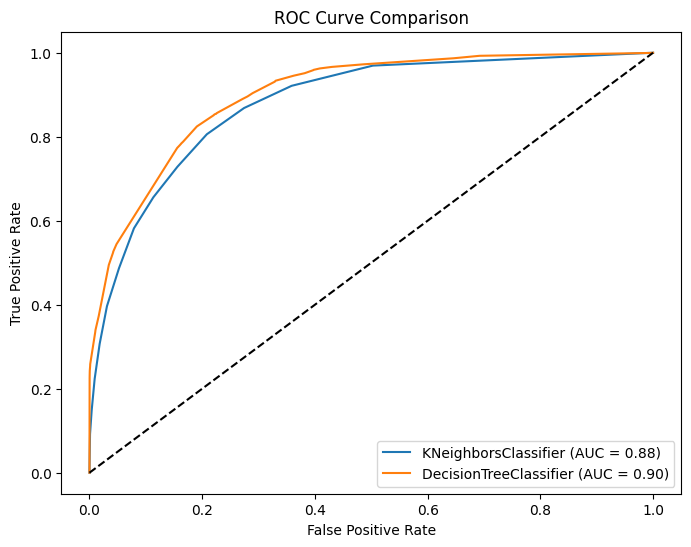

               k-NN  Decision Tree
Accuracy   0.836705       0.850493
Precision  0.709434       0.805340
Recall     0.581880       0.526168
F1         0.639357       0.636487
AUC        0.879395       0.900100


In [81]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, roc_curve, confusion_matrix)
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_prob)
    }

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{model.__class__.__name__} (AUC = {metrics['AUC']:.2f})")

    return metrics

# Evaluate both models
plt.figure(figsize=(8, 6))
knn_metrics = evaluate_model(knn_final, X_test, y_test)
dt_metrics = evaluate_model(dt_final, X_test, y_test)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

# Create comparison table
metrics_df = pd.DataFrame({'k-NN': knn_metrics, 'Decision Tree': dt_metrics})
print(metrics_df)

### Model yang Dibandingkan
1. **K-Nearest Neighbors (K-NN)**  
   - Parameter terbaik: `n_neighbors = 13`

2. **Decision Tree Classifier**  
   - Parameter: `max_depth = 7`, `min_samples_leaf = 4`, `random_state = 42`

---

### Matriks Evaluasi

| **Metode**        | **Accuracy** | **Precision** | **Recall** | **F1 Score** | **AUC**   |
|-------------------|--------------|---------------|------------|--------------|-----------|
| **K-NN**          | 0.8367       | 0.7094        | **0.5819** | 0.6394       | 0.8794    |
| **Decision Tree** | **0.8505**   | **0.8053**    | 0.5262     | **0.6365**   | **0.9001** |

---

### Penjelasan Metrik Evaluasi

1. **Accuracy (Akurasi)**  
   $$
   Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
   $$  
   Proporsi prediksi yang benar dari seluruh data.  
   > *DT lebih unggul (85.05% vs 83.67%)*

2. **Precision (Presisi)**  
   $$
   Precision = \frac{TP}{TP + FP}
   $$  
   Seberapa akurat model dalam memprediksi kelas positif.  
   > *DT lebih tinggi, berarti lebih sedikit false positive.*

3. **Recall (Sensitivity)**  
   $$
   Recall = \frac{TP}{TP + FN}
   $$  
   Seberapa baik model menangkap seluruh kasus positif sebenarnya.  
   > *K-NN unggul (58.19% vs 52.62%)* → lebih sensitif terhadap kelas positif.

4. **F1 Score**  
   $$
   F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}
   $$  
   Harmonik rata-rata antara presisi dan recall.  
   > *Hampir seimbang, K-NN sedikit lebih baik.*

5. **AUC (Area Under ROC Curve)**  
   $$
   AUC = int_0^1 TPR(FPR^{-1}(x)) dx
   $$  
   Mengukur kemampuan model membedakan antara kelas. Nilai mendekati 1 = sangat baik.  
   > *DT unggul (0.9001 vs 0.8794)* → model lebih baik dalam diskriminasi kelas.

---

### Analisis Kesimpulan

- **Decision Tree unggul secara keseluruhan** dalam hal:
  - **Akurasi**: lebih banyak prediksi benar.
  - **Presisi**: lebih andal dalam prediksi positif.
  - **AUC**: model lebih baik dalam membedakan kelas.
- **K-NN unggul dalam Recall**: lebih baik dalam menangkap semua kelas positif (false negative lebih sedikit).
- **F1 Score hampir imbang**, mencerminkan trade-off antara presisi dan recall.